# Retrieve Stock Data and Save to DF

In [28]:
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf

def get_stock(ticker, start_date, end_date, s_window, l_window):
    try:
        #yf.pdr_override()
        df = yf.download(ticker, start=start_date, end=end_date,auto_adjust=False)
        #print("DF: ",df)
# can use this as well        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        df['Return'] = df['Adj Close'].pct_change()
        df['Return'].fillna(0, inplace = True)
        df['Date'] = df.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year 
        df['Day'] = df['Date'].dt.day
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            df[col] = df[col].round(2)
        df['Weekday'] = df['Date'].dt.day_name()
        df['Week_Number'] = df['Date'].dt.strftime('%U')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
        df['Short_MA'] = df['Adj Close'].rolling(window=s_window, min_periods=1).mean()
        df['Long_MA'] = df['Adj Close'].rolling(window=l_window, min_periods=1).mean()        
        col_list = ['Date', 'Year', 'Month', 'Day', 'Weekday', 
                    'Week_Number', 'Year_Week', 'Open', 
                    'High', 'Low', 'Close', 'Volume', 'Adj Close',
                    'Return', 'Short_MA', 'Long_MA']
        num_lines = len(df)
        df = df[col_list]
        print('read ', num_lines, ' lines of data for ticker: ' , ticker)
        return df
    except Exception as error:
        print(error)
        return None

In [29]:
try:
    ticker='SPY'
    input_dir = os.getcwd()
    output_file = os.path.join(input_dir, ticker + '.csv')
    df = get_stock(ticker, start_date='2000-01-01', end_date='2025-07-08', 
               s_window=14, l_window=50)
    df.to_csv(output_file, index=False)
    print('wrote ' + str(len(df)) + ' lines to file: ' + output_file)
except Exception as e:
    print(e)
    print('failed to get Yahoo stock data for ticker: ', ticker)

[*********************100%***********************]  1 of 1 completed

read  2138  lines of data for ticker:  SPY
wrote 2138 lines to file: /Users/jonathanyan/Desktop/RISE DS/DS-Prac/Stock_market_proj/lstm-atr-prediction/stock-data/SPY.csv



/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)


In [30]:
#psuedocode
'''
1. create ATR column
2. create SD column
3. build LSTM columnn
4. split into train and test
5. train lstm on training data for ATR and test
6. train lstm on training data for SD and test
7. plot results and avg. returns based on decisions (buy if delta_volatility<-alpha, sell if delta_volatility>alpha)
'''

'\n1. create ATR column\n2. create SD column\n3. build LSTM columnn\n4. split into train and test\n5. train lstm on training data for ATR and test\n6. train lstm on training data for SD and test\n7. plot results and avg. returns based on decisions (buy if delta_volatility<-alpha, sell if delta_volatility>alpha)\n'

In [31]:
 #.xs returns a cross section; selects only values within the SPY indexes at level=1
df_n= df.xs('SPY',axis=1,level=1)
#cleaned up data

Price,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,225.04,225.83,223.88,225.24,91366500,196.12
2017-01-04,225.62,226.75,225.61,226.58,78744400,197.28
2017-01-05,226.27,226.58,225.48,226.40,78379000,197.13
2017-01-06,226.53,227.75,225.90,227.21,71559900,197.83
2017-01-09,226.91,227.07,226.42,226.46,46939700,197.18


In [32]:
# import math
# #challenge of how to deal with missing values in time series data
# #choose sliding window of length=N (could be 20?) N_lstmtraining>N_atrslidingwindow
# def atr_func(d):
#     running = 0
#     for i in range(len(d)):
#         high = d.loc[i,"High"]
#         low = d.loc[i,"Low"]
#         if i==0:
#             running += high-low
#             continue
#         if i>0:
#             y_close = d.loc[i,"Close"]
        
#         TR = max(high-low,max(math.abs(high-y_close),math.abs(low-y_close)))
#         running+=TR
#     return running/len(d)

# df_n['ATR'] = df_n.rolling(window=14).apply(atr_func)
# df_n

In [33]:
#define ATR columns
high = df_n["High"]
low = df_n["Low"]
close = df_n["Close"]

prev_close = close.shift(1)


tr = pd.concat([
    high - low,
    (high - prev_close).abs(),
    (low - prev_close).abs()
], axis=1).max(axis=1)

df_n["ATR"] = tr.rolling(7).mean()

/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/4206602609.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()


In [34]:
import numpy as np

log_diff = np.log(df_n["Close"]/df_n["Close"].shift(1))
df_n["SD_Log_Close"] = log_diff.rolling(7).std()
df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
df_n["SD_normalized"] = (df_n["SD_Log_Close"] - df_n["SD_Log_Close"].mean())/df_n["SD_Log_Close"].std()
#xlb, xle, 

/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/3540912812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["SD_Log_Close"] = log_diff.rolling(7).std()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/3540912812.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/3540912812.py:6: SettingWithCopyWarning: 
A value is trying to b

In [35]:
#drop na values (first 6 rows)
df_n = df_n.dropna()
df_n = df_n.reset_index()

In [36]:
(df_n.loc[1,"Date"] - df_n.loc[0,"Date"]).days

# log(c_n+1/c_c)

1

In [37]:
df_n["Delta_Days"] = [(df_n.loc[i,"Date"] - df_n.loc[0,"Date"]).days for i in range(len(df_n))]
#save clean data
df_n.to_csv("Clean_Data.csv")

In [38]:
#define lstm model
import torch
from torch.nn import *
import torch.nn.functional as F

class NN_LSTM(Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lstm = LSTM(input_size=input_size,hidden_size=30)
        self.fc = Linear(30,output_size)
    def activation(self,X):
        return F.relu(X)
    def forward(self,input):
        input,_ = self.lstm(input)
        input = self.fc(input[-1,:,:])
        return input #return the last prediction
#lstm_layer = LSTM(input_size=4,hidden_size=30)

In [39]:
#define PDE loss
def PDE_loss(v_hat):
    return 0
    #use torch.autograd to get PDE loss

In [46]:
df_n

Price,Date,Open,High,Low,Close,Volume,Adj Close,ATR,SD_Log_Close,ATR_normalized,SD_normalized,Delta_Days
0,2017-01-12,226.50,226.75,224.96,226.53,72113200,197.24,1.477143,0.003394,-1.055425,-0.789427,0
1,2017-01-13,226.73,227.40,226.69,227.05,62717900,197.69,1.385714,0.002685,-1.082798,-0.882351,1
2,2017-01-17,226.31,226.78,225.80,226.25,61240800,197.00,1.407143,0.003045,-1.076382,-0.835198,5
3,2017-01-18,226.54,226.80,225.90,226.75,54793300,197.43,1.271429,0.002805,-1.117013,-0.866559,6
4,2017-01-19,226.84,227.00,225.41,225.91,66608800,196.70,1.385714,0.002881,-1.082798,-0.856639,7
...,...,...,...,...,...,...,...,...,...,...,...,...
2126,2025-06-30,617.38,619.22,615.04,617.85,92502500,617.85,5.868571,0.005666,0.259310,-0.491955,3091
2127,2025-07-01,616.36,618.83,615.52,617.65,70030100,617.65,5.398571,0.004345,0.118598,-0.664973,3092
2128,2025-07-02,617.24,620.49,616.61,620.45,66510400,620.45,4.717143,0.003906,-0.085412,-0.722376,3093
2129,2025-07-03,622.45,626.28,622.43,625.34,51065800,625.34,4.450000,0.003185,-0.165391,-0.816784,3094


In [47]:
def tt_split(df_n,vol_metric):
    train = df_n.loc[[i<=len(df_n)*4/5 for i in range(len(df_n))]]
    X_train = train[["Open","Close","High","Low", vol_metric]].to_numpy()
    y_train = train[vol_metric].to_numpy()

    test = df_n.loc[[i>len(df_n)*4/5 for i in range(len(df_n))]]
    X_test = test[["Open","Close","High","Low", vol_metric]].to_numpy()
    y_test = test[vol_metric].to_numpy()
    return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = tt_split(df_n,"ATR_normalized")

#bollinger bands
#try moving median instead of moving average
#try moving quartiles instead of std; q3-q2  *1/2
#take longer time period - five years

#lstm,cnn,and rnn cant either predict directional volatiliy for xl stocks


In [48]:
def make_seq(X_train,y_train,X_test,y_test):
    T = 30  # sequence length (window size)
    X_seq = []
    y_seq = []
    X_seq_test = []
    y_seq_test = []

    for i in range(len(X_train) - T):
        X_seq.append(X_train[i:i+T])  # shape: [T, 4] <- what is wanted in lstm
        y_seq.append(y_train[i+T])    # predict next ATR value
    for i in range(len(X_test)-T):    
        X_seq_test.append(X_test[i:i+T])
        y_seq_test.append(y_test[i+T])


    X_seq = torch.tensor(X_seq, dtype=torch.float32)
    y_seq = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)
    X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32)
    y_seq_test = torch.tensor(y_seq_test, dtype=torch.float32).unsqueeze(1)
    
    return X_seq,y_seq,X_seq_test,y_seq_test
X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

In [49]:
from torch.utils.data import DataLoader, TensorDataset

def create_loaders(X_seq,y_seq,X_seq_test,y_seq_test,batch_size=64):
    dataset = TensorDataset(X_seq, y_seq)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    dataset_test = TensorDataset(X_seq_test,y_seq_test)
    loader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=True)
    return loader,loader_test
loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

In [56]:
#training loop
model = NN_LSTM(input_size=5,output_size=1)
epochs = 100
optim = torch.optim.Adam(params = model.parameters())
crit = MSELoss()
losses = []
losses_test = []

for i in range(epochs):
    running_loss = 0
    for x_window,y_atr in loader:
        #print("Running")
        input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
        out = model(input)
        #print(y_atr.shape)
        #print(out,y_atr)
        #break
        loss = crit(out,y_atr)
        running_loss+=loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
            # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
    #break
    running_loss/=(len(loader))
    print(f"Training Loss: {running_loss}")
    losses.append(running_loss)

    with torch.no_grad():
        testing_loss = 0
        for x_window_test,y_atr_test in loader_test:
            out_test = model(x_window_test.permute(1,0,2))
            #print(y_atr_test.shape)
            loss = crit(out_test,y_atr_test)
            testing_loss+=loss.item()
        losses_test.append(testing_loss/(len(loader_test)))


Training Loss: 0.8182580879441014
Training Loss: 0.7609609950471807
Training Loss: 0.7619970860304656
Training Loss: 0.7350581785043081
Training Loss: 0.7018964522414737
Training Loss: 0.6613246003786722
Training Loss: 0.6445599132113986
Training Loss: 0.6029560014053628
Training Loss: 0.5541633913914362
Training Loss: 0.5204195402286671
Training Loss: 0.478655727925124
Training Loss: 0.4334823395367022
Training Loss: 0.39057346902511736
Training Loss: 0.3587734966918274
Training Loss: 0.3287808977895313
Training Loss: 0.29927088941137
Training Loss: 0.27818455464310116
Training Loss: 0.2556159699128734
Training Loss: 0.24450635578897265
Training Loss: 0.23555890622514267
Training Loss: 0.24412422158099986
Training Loss: 0.20365372079390068
Training Loss: 0.19491071902491428
Training Loss: 0.18212456476909142
Training Loss: 0.17471375854478943
Training Loss: 0.17466304975527305
Training Loss: 0.21586919989850786
Training Loss: 0.15766040401326287
Training Loss: 0.1573603026292942
Train

Text(0.5, 1.0, 'Training Loss of LSTM (ATR_normalized) across 60 epochs')

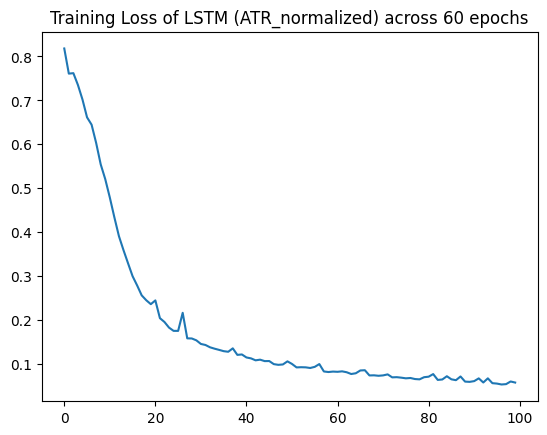

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=[i for i in range(len(losses))],y=losses)
plt.title("Training Loss of LSTM (ATR_normalized) across 60 epochs")

Text(0.5, 1.0, 'Testing Loss of LSTM (ATR_normalized) across 60 epochs')

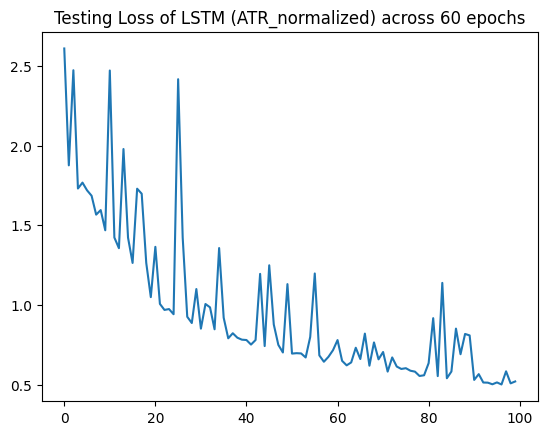

In [58]:
sns.lineplot(losses_test)
plt.title("Testing Loss of LSTM (ATR_normalized) across 60 epochs")

In [59]:
X_train_sd,y_train_sd,X_test_sd,y_test_sd = tt_split(df_n,vol_metric="SD_normalized")
X_seq_sd,y_seq_sd,X_seq_test_sd,y_seq_test_sd = make_seq(X_train_sd,y_train_sd,X_test_sd,y_test_sd)
loader_sd,loader_test_sd = create_loaders(X_seq_sd,y_seq_sd,X_seq_test_sd,y_seq_test_sd)

In [63]:
#training loop
model_sd = NN_LSTM(input_size=5,output_size=1)
epochs = 100
optim = torch.optim.Adam(params = model_sd.parameters())
crit = MSELoss()
losses = []
losses_test = []

for i in range(epochs):
    running_loss = 0
    for x_window,y_sd in loader_sd:
        #print("Running")
        input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
        out = model_sd(input)
        #print(y_sd.shape)
        loss = crit(out,y_sd)
        running_loss+=loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
            # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
    running_loss/=(len(loader_sd))
    print(f"Training Loss: {running_loss}")
    losses.append(running_loss)

    with torch.no_grad():
        testing_loss = 0
        for x_window_test,y_sd_test in loader_test_sd:
            out_test = model_sd(x_window_test.permute(1,0,2))
            #print(y_sd_test.shape)
            loss = crit(out_test,y_sd_test)
            testing_loss+=loss.item()
        losses_test.append(testing_loss/(len(loader_test_sd)))


Training Loss: 1.0322876351851005
Training Loss: 0.9794860504291676
Training Loss: 0.9265823629167345
Training Loss: 0.9076506396134695
Training Loss: 0.8411113321781158
Training Loss: 0.7917189366287656
Training Loss: 0.7321434335576164
Training Loss: 0.6907505100523984
Training Loss: 0.7051983310116662
Training Loss: 0.6201332043166514
Training Loss: 0.5876012902568888
Training Loss: 0.5467103018804833
Training Loss: 0.5258259941582326
Training Loss: 0.5148503923857654
Training Loss: 0.4947674853934182
Training Loss: 0.4866635161969397
Training Loss: 0.4795781986580955
Training Loss: 0.461015947163105
Training Loss: 0.45631197426054215
Training Loss: 0.44261058971837713
Training Loss: 0.4285906315953643
Training Loss: 0.46430777620386193
Training Loss: 0.44412487414148116
Training Loss: 0.40814788749924413
Training Loss: 0.398749900912797
Training Loss: 0.394867115550571
Training Loss: 0.3749742066418683
Training Loss: 0.3907581556726385
Training Loss: 0.4090284009774526
Training Los

Text(0.5, 1.0, 'Training Loss of LSTM (SD__normalized) across 60 epochs')

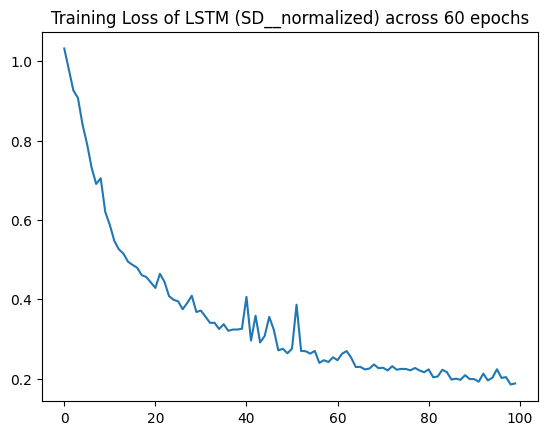

In [64]:
sns.lineplot(losses)
plt.title("Training Loss of LSTM (SD__normalized) across 60 epochs")

Text(0.5, 1.0, 'Testing Loss of LSTM (SD_normalized) across 60 epochs')

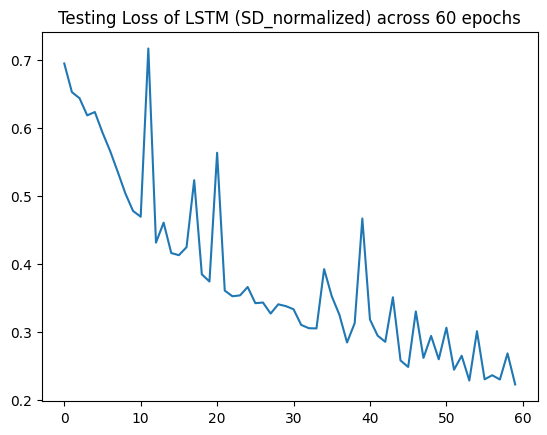

In [62]:
sns.lineplot(losses_test)
plt.title("Testing Loss of LSTM (SD_normalized) across 60 epochs")

In [ ]:
#use past atrs
#try transformations of atr log(atr)

In [66]:
def pipeline(ticker,start,end,metric):
    df = get_stock(ticker,start_date=start,end_date=end,s_window=14,l_window=50)
    df_n= df.xs(ticker,axis=1,level=1)
    
        #define ATR columns
    high = df_n["High"]
    low = df_n["Low"]
    close = df_n["Close"]

    prev_close = close.shift(1)


    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    df_n["ATR"] = tr.rolling(7).mean()
    
    log_diff = np.log(df_n["Close"]/df_n["Close"].shift(1))
    df_n["SD_Log_Close"] = log_diff.rolling(7).std()
    df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
    df_n["SD_normalized"] = (df_n["SD_Log_Close"] - df_n["SD_Log_Close"].mean())/df_n["SD_Log_Close"].std()

    df_n = df_n.dropna()
    df_n = df_n.reset_index()   

    X_train,y_train,X_test,y_test = tt_split(df_n, metric)

    X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

    loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

    #training loop
    
    model = NN_LSTM(input_size=5,output_size=1)
    epochs = 100
    optim = torch.optim.Adam(params = model.parameters())
    crit = MSELoss()
    losses = []
    losses_test = []

    for i in range(epochs):
        running_loss = 0
        for x_window,y_atr in loader:
            #print("Running")
            input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
            out = model(input)
            #print(y_atr.shape)
            #print(out,y_atr)
            #break
            loss = crit(out,y_atr)
            running_loss+=loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
                # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
        #break
        running_loss/=(len(loader))
        print(f"Training Loss: {running_loss}")
        losses.append(running_loss)

        with torch.no_grad():
            testing_loss = 0
            for x_window_test,y_atr_test in loader_test:
                out_test = model(x_window_test.permute(1,0,2))
                #print(y_atr_test.shape)
                loss = crit(out_test,y_atr_test)
                testing_loss+=loss.item()
            losses_test.append(testing_loss/(len(loader_test)))

    sns.lineplot(x=[i for i in range(len(losses))],y=losses)
    plt.title("Training Loss of LSTM (ATR_normalized) across 60 epochs")
    plt.show()

    sns.lineplot(losses_test)
    plt.title("Testing Loss of LSTM (ATR_normalized) across 60 epochs")
    plt.show()

    

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/416295630.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/416295630.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

read  6419  lines of data for ticker:  SPY
Training Loss: 0.394067776016891
Training Loss: 0.30023263217881324
Training Loss: 0.22651336152339355
Training Loss: 0.18233207772718743
Training Loss: 0.14639966808026655
Training Loss: 0.1280633353162557
Training Loss: 0.11774335254449397
Training Loss: 0.10484261108795181
Training Loss: 0.09466624370543286
Training Loss: 0.08508102435735054
Training Loss: 0.080828269966878
Training Loss: 0.07646019200328738
Training Loss: 0.07304326576413586
Training Loss: 0.07020290112122893
Training Loss: 0.06291172401979565
Training Loss: 0.05668004378094338
Training Loss: 0.05789815651369281
Training Loss: 0.07947792841587216
Training Loss: 0.05422955882968381
Training Loss: 0.05120680702966638
Training Loss: 0.0475519064348191
Training Loss: 0.04439685482357163
Training Loss: 0.042040123633341864
Training Loss: 0.040680714254267517
Training Loss: 0.035996211768360806
Training Loss: 0.036012995336204764
Training Loss: 0.036167772032786163
Training Loss

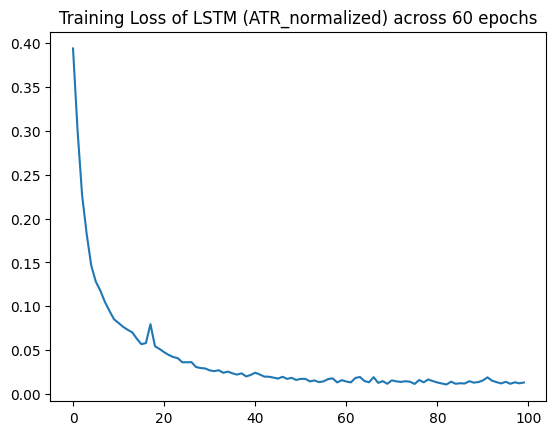

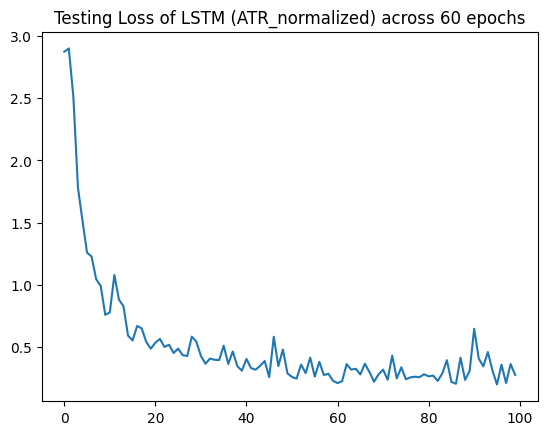

In [67]:
start = "2000-01-01"
end = "2025-07-14"
pipeline("SPY",start,end,metric="ATR_normalized")

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/416295630.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/416295630.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

read  6419  lines of data for ticker:  XLP
Training Loss: 0.6254632321186364
Training Loss: 0.5676096381619573
Training Loss: 0.439227373059839
Training Loss: 0.2896065467968583
Training Loss: 0.23013532024342567
Training Loss: 0.17864365151617675
Training Loss: 0.15067831466440113
Training Loss: 0.13098890859400852
Training Loss: 0.11625248728087172
Training Loss: 0.09590275334194302
Training Loss: 0.07999322267714888
Training Loss: 0.06918626058613882
Training Loss: 0.06588245010352693
Training Loss: 0.06096512919757515
Training Loss: 0.055546047317329796
Training Loss: 0.05283291754312813
Training Loss: 0.04710026241955347
Training Loss: 0.04742531221127137
Training Loss: 0.04533514968352392
Training Loss: 0.04118535093148239
Training Loss: 0.04376565102720633
Training Loss: 0.040373221831396224
Training Loss: 0.03515660366392694
Training Loss: 0.03656390437972732
Training Loss: 0.03465371774509549
Training Loss: 0.03305004245485179
Training Loss: 0.03165503110503778
Training Loss: 

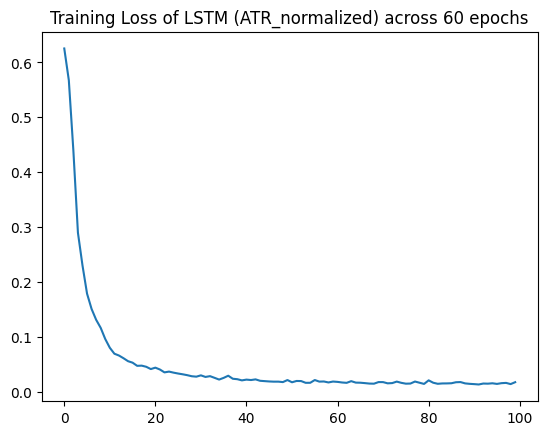

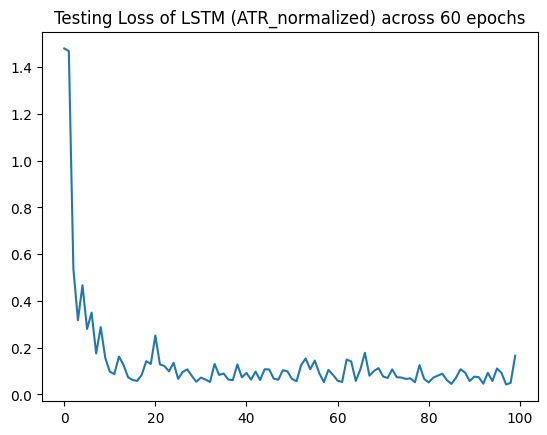

In [68]:
pipeline("XLP",start,end,metric="ATR_normalized")

[*********************100%***********************]  1 of 1 completed
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/416295630.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()
/var/folders/q9/9j4tq0z16h37tyl8y408ycs40000gn/T/ipykernel_52328/416295630.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

read  6419  lines of data for ticker:  XLP
Training Loss: 1.0730869632214308
Training Loss: 1.0085822757333518
Training Loss: 0.9664197720587253
Training Loss: 0.7366598132997751
Training Loss: 0.5864134272560477
Training Loss: 0.48744277376681566
Training Loss: 0.42094640973955394
Training Loss: 0.38043055441230533
Training Loss: 0.3526863352395594
Training Loss: 0.34351924834772946
Training Loss: 0.31937807323411105
Training Loss: 0.30207163793966174
Training Loss: 0.3234192444011569
Training Loss: 0.28087837183848025
Training Loss: 0.2951045475900173
Training Loss: 0.2744728333316743
Training Loss: 0.2861547443084419
Training Loss: 0.27523800674825905
Training Loss: 0.2610622774809599
Training Loss: 0.27429946009069683
Training Loss: 0.2581875200383365
Training Loss: 0.24924247078597545
Training Loss: 0.25462703220546246
Training Loss: 0.24743280801922082
Training Loss: 0.2411614615470171
Training Loss: 0.25132100293412807
Training Loss: 0.24278211677446962
Training Loss: 0.23657560

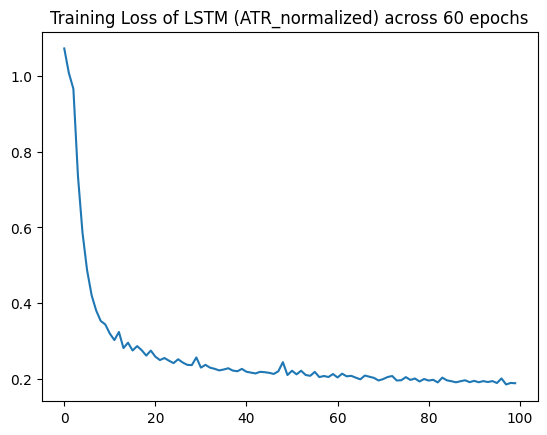

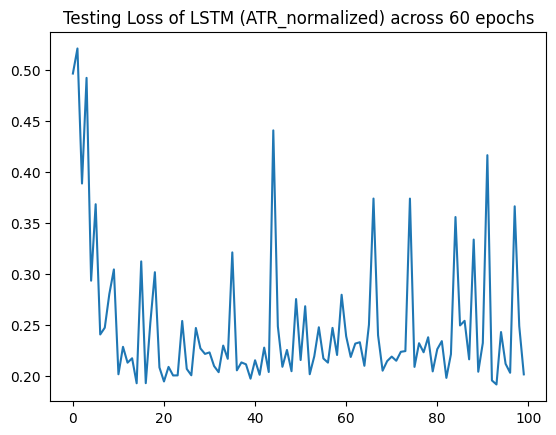

In [69]:
pipeline("XLP",start,end,metric="SD_normalized")